In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from jupyterplot import ProgressPlot

from nn_sim.data import DataLoader, DatasetNN
from nn_sim.net import layers as nn_layers
from nn_sim.net.layers import (
    Module, Sigmoid, ReLU, IdentityActivation, 
    Step, Softmax, SSELoss, MSELoss, MAELoss, BinaryCrossEntropyLoss,
    CategoricalCrossEntropyLoss,
    HiddenLayer,)
from nn_sim.net.feedfoward import FeedFowardNeuralNetwork

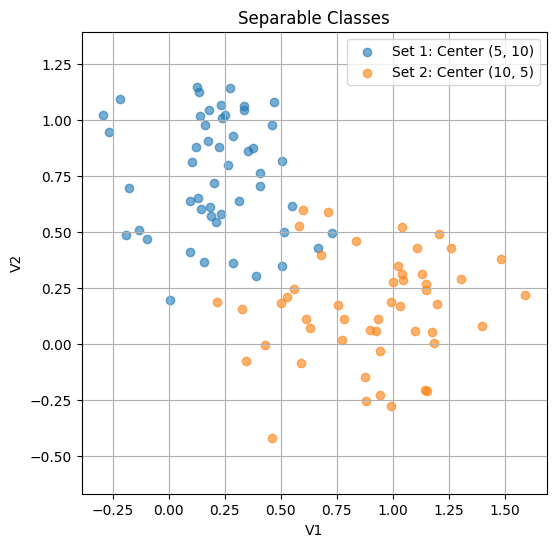

In [3]:
# Parameters for the first set of points
num_points_1 = 50
x_center_1 = 0.25
y_center_1 = 0.8
sigma_1 = 0.25

# Parameters for the second set of points
num_points_2 = 50
x_center_2 = 0.9
y_center_2 = 0.2
sigma_2 = 0.25

# Generating the first set of random points
v1_c1 = np.random.normal(x_center_1, sigma_1, num_points_1)
v2_c1 = np.random.normal(y_center_1, sigma_1, num_points_1)
points_1 = np.column_stack((v1_c1, v2_c1)).astype(np.float32)

# Generating the second set of random points
v1_c2 = np.random.normal(x_center_2, sigma_2, num_points_2)
v2_c2 = np.random.normal(y_center_2, sigma_2, num_points_2)
points_2 = np.column_stack((v1_c2, v2_c2)).astype(np.float32)

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(points_1[:, 0], points_1[:, 1], alpha=0.6, label='Set 1: Center (5, 10)')
plt.scatter(points_2[:, 0], points_2[:, 1], alpha=0.6, label='Set 2: Center (10, 5)')
plt.title('Separable Classes')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1707.74it/s]

0.0006643423736720935


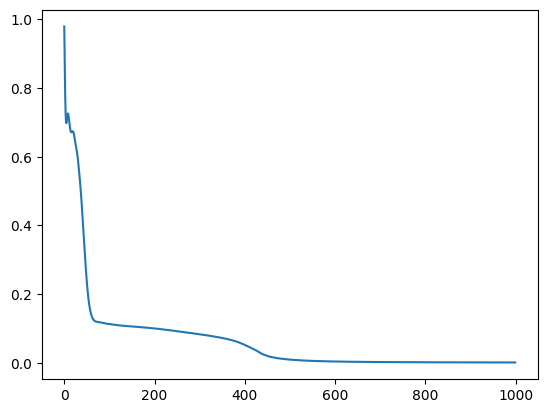

In [21]:
net = FeedFowardNeuralNetwork(
    2, # input size
    [
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (1, True, Sigmoid()), # output layer
    ]
)

X = np.vstack((points_1, points_2))
Y = np.vstack((
    np.zeros((points_1.shape[0], 1), dtype=np.float32),
    np.ones((points_2.shape[0], 1), dtype=np.float32),)
)


class BCELoss(Module):
    
    def __init__(self) -> None:
        pass

    def __call__(self, *args) -> np.ndarray:
        return self.forward(*args)

    def forward(self, y_pred, y_true) -> np.ndarray:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1 - y_pred))
        return loss
    
    def diff(self, y_pred, y_true) -> np.ndarray:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        gradient = -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))
        return gradient


for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)



loss_func = BCELoss()
learning_rate = 0.01
momentum = 0.95  # Common values are between 0.9 and 0.99
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-7

MAX_EPOCHS = 1000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    
    net.zero_gradients()
    
    y_pred = net(X)
    loss = loss_func(y_pred, Y)
    losses.append(loss)
    
    net.backward(y_pred, Y, loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        # Update first moment estimate
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        # Update second moment estimate
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        # Compute bias-corrected first and second moment estimates
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        # Update parameters
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)

print(loss)
plt.plot(losses)
plt.show()

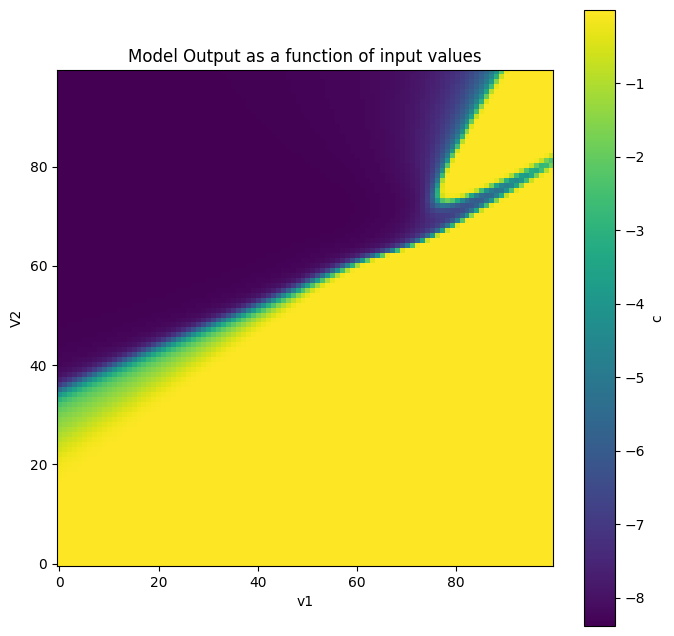

In [22]:
resolution = 100
grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, resolution), np.linspace(-1, 1, resolution))
input_grid = np.column_stack([grid_x.flatten(), grid_y.flatten()])  # Flatten the grid for processing


predictions = net(input_grid)
    

predictions = np.array(predictions).reshape((resolution, resolution))

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(np.log(predictions), origin='lower', cmap='viridis')
plt.colorbar(label='c')
plt.xlabel('v1')
plt.ylabel('V2')
plt.title('Model Output as a function of input values')
plt.show()